In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms
import os 
from PIL import Image
import matplotlib.pyplot as plt

Defining the model

In [3]:
def conv_block(in_channels, out_channels, activation=False, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels)]
    if activation: layers.append(nn.ReLU(inplace=True))
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet34(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=7, stride=1, padding=4),
            nn.BatchNorm2d(64),nn.MaxPool2d(2), nn.ReLU(inplace=True))
           
        self.res1 = nn.Sequential(conv_block(64, 64,activation=True), conv_block(64, 64))
        self.res2 = nn.Sequential(conv_block(64, 64,activation=True), conv_block(64, 64))
        self.res3 = nn.Sequential(conv_block(64, 64,activation=True), conv_block(64, 64))
        self.downsample1=nn.Sequential(conv_block(64, 128,pool=True)) 
        self.res4 = nn.Sequential(conv_block(64, 128,activation=True, pool=True),
                                  conv_block(128,128))
        self.res5 = nn.Sequential(conv_block(128, 128,activation=True), conv_block(128, 128))
        self.res6 = nn.Sequential(conv_block(128, 128,activation=True), conv_block(128, 128))
        self.res7 = nn.Sequential(conv_block(128, 128,activation=True), conv_block(128, 128))
        self.res8 = nn.Sequential(conv_block(128, 256,activation=True, pool=True),
                                  conv_block(256,256))
        self.downsample2 = nn.Sequential(conv_block(128, 256,pool=True))
        self.res9 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res10 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res11 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res12 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res13 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res14 = nn.Sequential(conv_block(256, 512,activation=True, pool=True),
                                   conv_block(512,512))
        
        self.downsample3 = nn.Sequential(conv_block(256, 512,pool=True))
        self.res15 = nn.Sequential(conv_block(512, 512,activation=True), conv_block(512, 512))
        self.res16 = nn.Sequential(conv_block(512, 512,activation=True), conv_block(512, 512,activation=True))

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d((1,1)), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.17),
                                        nn.Linear(512, num_classes))
      
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.res1(out) + out
        out = self.res2(out) + out
        out = self.res3(out) + out
        out = self.downsample1(out) +self.res4(out)
        out = self.res5(out) + out
        out = self.res6(out) + out
        out = self.res7(out) + out
        out = self.downsample2(out) +self.res8(out)
        out = self.res9(out) + out
        out = self.res10(out) + out
        out = self.res11(out) + out
        out = self.res12(out) + out
        out = self.res13(out) + out
        out = self.downsample3(out) + self.res14(out) 
        out = self.res15(out) + out
        out = self.res16(out) + out
        out = self.classifier(out)
        return (out)

Making list of the classes

In [4]:
bird_name_map= {0: 'ABBOTTS BABBLER', 1: 'ABBOTTS BOOBY', 2: 'ABYSSINIAN GROUND HORNBILL', 3: 'AFRICAN CROWNED CRANE', 4: 'AFRICAN EMERALD CUCKOO', 5: 'AFRICAN FIREFINCH', 6: 'AFRICAN OYSTER CATCHER', 7: 'AFRICAN PIED HORNBILL', 8: 'ALBATROSS', 9: 'ALBERTS TOWHEE', 10: 'ALEXANDRINE PARAKEET', 11: 'ALPINE CHOUGH', 12: 'ALTAMIRA YELLOWTHROAT', 13: 'AMERICAN AVOCET', 14: 'AMERICAN BITTERN', 15: 'AMERICAN COOT', 16: 'AMERICAN FLAMINGO', 17: 'AMERICAN GOLDFINCH', 18: 'AMERICAN KESTREL', 19: 'AMERICAN PIPIT', 20: 'AMERICAN REDSTART', 21: 'AMERICAN WIGEON', 22: 'AMETHYST WOODSTAR', 23: 'ANDEAN GOOSE', 24: 'ANDEAN LAPWING', 25: 'ANDEAN SISKIN', 26: 'ANHINGA', 27: 'ANIANIAU', 28: 'ANNAS HUMMINGBIRD', 29: 'ANTBIRD', 30: 'ANTILLEAN EUPHONIA', 31: 'APAPANE', 32: 'APOSTLEBIRD', 33: 'ARARIPE MANAKIN', 34: 'ASHY STORM PETREL', 35: 'ASHY THRUSHBIRD', 36: 'ASIAN CRESTED IBIS', 37: 'ASIAN DOLLARD BIRD', 38: 'AUCKLAND SHAQ', 39: 'AUSTRAL CANASTERO', 40: 'AUSTRALASIAN FIGBIRD', 41: 'AVADAVAT', 42: 'AZARAS SPINETAIL', 43: 'AZURE BREASTED PITTA', 44: 'AZURE JAY', 45: 'AZURE TANAGER', 46: 'AZURE TIT', 47: 'BAIKAL TEAL', 48: 'BALD EAGLE', 49: 'BALD IBIS', 50: 'BALI STARLING', 51: 'BALTIMORE ORIOLE', 52: 'BANANAQUIT', 53: 'BAND TAILED GUAN', 54: 'BANDED BROADBILL', 55: 'BANDED PITA', 56: 'BANDED STILT', 57: 'BAR-TAILED GODWIT', 58: 'BARN OWL', 59: 'BARN SWALLOW', 60: 'BARRED PUFFBIRD', 61: 'BARROWS GOLDENEYE', 62: 'BAY-BREASTED WARBLER', 63: 'BEARDED BARBET', 64: 'BEARDED BELLBIRD', 65: 'BEARDED REEDLING', 66: 'BELTED KINGFISHER', 67: 'BIRD OF PARADISE', 68: 'BLACK & YELLOW BROADBILL', 69: 'BLACK BAZA', 70: 'BLACK COCKATO', 71: 'BLACK FRANCOLIN', 72: 'BLACK SKIMMER', 73: 'BLACK SWAN', 74: 'BLACK TAIL CRAKE', 75: 'BLACK THROATED BUSHTIT', 76: 'BLACK THROATED WARBLER', 77: 'BLACK VENTED SHEARWATER', 78: 'BLACK VULTURE', 79: 'BLACK-CAPPED CHICKADEE', 80: 'BLACK-NECKED GREBE', 81: 'BLACK-THROATED SPARROW', 82: 'BLACKBURNIAM WARBLER', 83: 'BLONDE CRESTED WOODPECKER', 84: 'BLOOD PHEASANT', 85: 'BLUE COAU', 86: 'BLUE DACNIS', 87: 'BLUE GROUSE', 88: 'BLUE HERON', 89: 'BLUE MALKOHA', 90: 'BLUE THROATED TOUCANET', 91: 'BOBOLINK', 92: 'BORNEAN BRISTLEHEAD', 93: 'BORNEAN LEAFBIRD', 94: 'BORNEAN PHEASANT', 95: 'BRANDT CORMARANT', 96: 'BREWERS BLACKBIRD', 97: 'BROWN CREPPER', 98: 'BROWN NOODY', 99: 'BROWN THRASHER', 100: 'BUFFLEHEAD', 101: 'BULWERS PHEASANT', 102: 'BURCHELLS COURSER', 103: 'BUSH TURKEY', 104: 'CAATINGA CACHOLOTE', 105: 'CACTUS WREN', 106: 'CALIFORNIA CONDOR', 107: 'CALIFORNIA GULL', 108: 'CALIFORNIA QUAIL', 109: 'CAMPO FLICKER', 110: 'CANARY', 111: 'CAPE GLOSSY STARLING', 112: 'CAPE LONGCLAW', 113: 'CAPE MAY WARBLER', 114: 'CAPE ROCK THRUSH', 115: 'CAPPED HERON', 116: 'CAPUCHINBIRD', 117: 'CARMINE BEE-EATER', 118: 'CASPIAN TERN', 119: 'CASSOWARY', 120: 'CEDAR WAXWING', 121: 'CERULEAN WARBLER', 122: 'CHARA DE COLLAR', 123: 'CHATTERING LORY', 124: 'CHESTNET BELLIED EUPHONIA', 125: 'CHINESE BAMBOO PARTRIDGE', 126: 'CHINESE POND HERON', 127: 'CHIPPING SPARROW', 128: 'CHUCAO TAPACULO', 129: 'CHUKAR PARTRIDGE', 130: 'CINNAMON ATTILA', 131: 'CINNAMON FLYCATCHER', 132: 'CINNAMON TEAL', 133: 'CLARKS NUTCRACKER', 134: 'COCK OF THE  ROCK', 135: 'COCKATOO', 136: 'COLLARED ARACARI', 137: 'COMMON FIRECREST', 138: 'COMMON GRACKLE', 139: 'COMMON HOUSE MARTIN', 140: 'COMMON IORA', 141: 'COMMON LOON', 142: 'COMMON POORWILL', 143: 'COMMON STARLING', 144: 'COPPERY TAILED COUCAL', 145: 'CRAB PLOVER', 146: 'CRANE HAWK', 147: 'CREAM COLORED WOODPECKER', 148: 'CRESTED AUKLET', 149: 'CRESTED CARACARA', 150: 'CRESTED COUA', 151: 'CRESTED FIREBACK', 152: 'CRESTED KINGFISHER', 153: 'CRESTED NUTHATCH', 154: 'CRESTED OROPENDOLA', 155: 'CRESTED SHRIKETIT', 156: 'CRIMSON CHAT', 157: 'CRIMSON SUNBIRD', 158: 'CROW', 159: 'CROWNED PIGEON', 160: 'CUBAN TODY', 161: 'CUBAN TROGON', 162: 'CURL CRESTED ARACURI', 163: 'D-ARNAUDS BARBET', 164: 'DALMATIAN PELICAN', 165: 'DARJEELING WOODPECKER', 166: 'DARK EYED JUNCO', 167: 'DARWINS FLYCATCHER', 168: 'DAURIAN REDSTART', 169: 'DEMOISELLE CRANE', 170: 'DOUBLE BARRED FINCH', 171: 'DOUBLE BRESTED CORMARANT', 172: 'DOUBLE EYED FIG PARROT', 173: 'DOWNY WOODPECKER', 174: 'DUSKY LORY', 175: 'DUSKY ROBIN', 176: 'EARED PITA', 177: 'EASTERN BLUEBIRD', 178: 'EASTERN BLUEBONNET', 179: 'EASTERN GOLDEN WEAVER', 180: 'EASTERN MEADOWLARK', 181: 'EASTERN ROSELLA', 182: 'EASTERN TOWEE', 183: 'EASTERN WIP POOR WILL', 184: 'ECUADORIAN HILLSTAR', 185: 'EGYPTIAN GOOSE', 186: 'ELEGANT TROGON', 187: 'ELLIOTS  PHEASANT', 188: 'EMERALD TANAGER', 189: 'EMPEROR PENGUIN', 190: 'EMU', 191: 'ENGGANO MYNA', 192: 'EURASIAN BULLFINCH', 193: 'EURASIAN GOLDEN ORIOLE', 194: 'EURASIAN MAGPIE', 195: 'EUROPEAN GOLDFINCH', 196: 'EUROPEAN TURTLE DOVE', 197: 'EVENING GROSBEAK', 198: 'FAIRY BLUEBIRD', 199: 'FAIRY PENGUIN', 200: 'FAIRY TERN', 201: 'FAN TAILED WIDOW', 202: 'FASCIATED WREN', 203: 'FIERY MINIVET', 204: 'FIORDLAND PENGUIN', 205: 'FIRE TAILLED MYZORNIS', 206: 'FLAME BOWERBIRD', 207: 'FLAME TANAGER', 208: 'FRIGATE', 209: 'GAMBELS QUAIL', 210: 'GANG GANG COCKATOO', 211: 'GILA WOODPECKER', 212: 'GILDED FLICKER', 213: 'GLOSSY IBIS', 214: 'GO AWAY BIRD', 215: 'GOLD WING WARBLER', 216: 'GOLDEN BOWER BIRD', 217: 'GOLDEN CHEEKED WARBLER', 218: 'GOLDEN CHLOROPHONIA', 219: 'GOLDEN EAGLE', 220: 'GOLDEN PARAKEET', 221: 'GOLDEN PHEASANT', 222: 'GOLDEN PIPIT', 223: 'GOULDIAN FINCH', 224: 'GRANDALA', 225: 'GRAY CATBIRD', 226: 'GRAY KINGBIRD', 227: 'GRAY PARTRIDGE', 228: 'GREAT GRAY OWL', 229: 'GREAT JACAMAR', 230: 'GREAT KISKADEE', 231: 'GREAT POTOO', 232: 'GREAT TINAMOU', 233: 'GREAT XENOPS', 234: 'GREATER PEWEE', 235: 'GREATOR SAGE GROUSE', 236: 'GREEN BROADBILL', 237: 'GREEN JAY', 238: 'GREEN MAGPIE', 239: 'GREY CUCKOOSHRIKE', 240: 'GREY PLOVER', 241: 'GROVED BILLED ANI', 242: 'GUINEA TURACO', 243: 'GUINEAFOWL', 244: 'GURNEYS PITTA', 245: 'GYRFALCON', 246: 'HAMERKOP', 247: 'HARLEQUIN DUCK', 248: 'HARLEQUIN QUAIL', 249: 'HARPY EAGLE', 250: 'HAWAIIAN GOOSE', 251: 'HAWFINCH', 252: 'HELMET VANGA', 253: 'HEPATIC TANAGER', 254: 'HIMALAYAN BLUETAIL', 255: 'HIMALAYAN MONAL', 256: 'HOATZIN', 257: 'HOODED MERGANSER', 258: 'HOOPOES', 259: 'HORNED GUAN', 260: 'HORNED LARK', 261: 'HORNED SUNGEM', 262: 'HOUSE FINCH', 263: 'HOUSE SPARROW', 264: 'HYACINTH MACAW', 265: 'IBERIAN MAGPIE', 266: 'IBISBILL', 267: 'IMPERIAL SHAQ', 268: 'INCA TERN', 269: 'INDIAN BUSTARD', 270: 'INDIAN PITTA', 271: 'INDIAN ROLLER', 272: 'INDIAN VULTURE', 273: 'INDIGO BUNTING', 274: 'INDIGO FLYCATCHER', 275: 'INLAND DOTTEREL', 276: 'IVORY BILLED ARACARI', 277: 'IVORY GULL', 278: 'IWI', 279: 'JABIRU', 280: 'JACK SNIPE', 281: 'JANDAYA PARAKEET', 282: 'JAPANESE ROBIN', 283: 'JAVA SPARROW', 284: 'JOCOTOCO ANTPITTA', 285: 'KAGU', 286: 'KAKAPO', 287: 'KILLDEAR', 288: 'KING EIDER', 289: 'KING VULTURE', 290: 'KIWI', 291: 'KOOKABURRA', 292: 'LARK BUNTING', 293: 'LAZULI BUNTING', 294: 'LESSER ADJUTANT', 295: 'LILAC ROLLER', 296: 'LITTLE AUK', 297: 'LOGGERHEAD SHRIKE', 298: 'LONG-EARED OWL', 299: 'MAGPIE GOOSE', 300: 'MALABAR HORNBILL', 301: 'MALACHITE KINGFISHER', 302: 'MALAGASY WHITE EYE', 303: 'MALEO', 304: 'MALLARD DUCK', 305: 'MANDRIN DUCK', 306: 'MANGROVE CUCKOO', 307: 'MARABOU STORK', 308: 'MASKED BOOBY', 309: 'MASKED LAPWING', 310: 'MCKAYS BUNTING', 311: 'MIKADO  PHEASANT', 312: 'MOURNING DOVE', 313: 'MYNA', 314: 'NICOBAR PIGEON', 315: 'NOISY FRIARBIRD', 316: 'NORTHERN BEARDLESS TYRANNULET', 317: 'NORTHERN CARDINAL', 318: 'NORTHERN FLICKER', 319: 'NORTHERN FULMAR', 320: 'NORTHERN GANNET', 321: 'NORTHERN GOSHAWK', 322: 'NORTHERN JACANA', 323: 'NORTHERN MOCKINGBIRD', 324: 'NORTHERN PARULA', 325: 'NORTHERN RED BISHOP', 326: 'NORTHERN SHOVELER', 327: 'OCELLATED TURKEY', 328: 'OKINAWA RAIL', 329: 'ORANGE BRESTED BUNTING', 330: 'ORIENTAL BAY OWL', 331: 'OSPREY', 332: 'OSTRICH', 333: 'OVENBIRD', 334: 'OYSTER CATCHER', 335: 'PAINTED BUNTING', 336: 'PALILA', 337: 'PARADISE TANAGER', 338: 'PARAKETT  AKULET', 339: 'PARUS MAJOR', 340: 'PATAGONIAN SIERRA FINCH', 341: 'PEACOCK', 342: 'PEREGRINE FALCON', 343: 'PHILIPPINE EAGLE', 344: 'PINK ROBIN', 345: 'POMARINE JAEGER', 346: 'PUFFIN', 347: 'PURPLE FINCH', 348: 'PURPLE GALLINULE', 349: 'PURPLE MARTIN', 350: 'PURPLE SWAMPHEN', 351: 'PYGMY KINGFISHER', 352: 'QUETZAL', 353: 'RAINBOW LORIKEET', 354: 'RAZORBILL', 355: 'RED BEARDED BEE EATER', 356: 'RED BELLIED PITTA', 357: 'RED BROWED FINCH', 358: 'RED FACED CORMORANT', 359: 'RED FACED WARBLER', 360: 'RED FODY', 361: 'RED HEADED DUCK', 362: 'RED HEADED WOODPECKER', 363: 'RED HONEY CREEPER', 364: 'RED NAPED TROGON', 365: 'RED TAILED HAWK', 366: 'RED TAILED THRUSH', 367: 'RED WINGED BLACKBIRD', 368: 'RED WISKERED BULBUL', 369: 'REGENT BOWERBIRD', 370: 'RING-NECKED PHEASANT', 371: 'ROADRUNNER', 372: 'ROBIN', 373: 'ROCK DOVE', 374: 'ROSY FACED LOVEBIRD', 375: 'ROUGH LEG BUZZARD', 376: 'ROYAL FLYCATCHER', 377: 'RUBY THROATED HUMMINGBIRD', 378: 'RUDY KINGFISHER', 379: 'RUFOUS KINGFISHER', 380: 'RUFUOS MOTMOT', 381: 'SAMATRAN THRUSH', 382: 'SAND MARTIN', 383: 'SANDHILL CRANE', 384: 'SATYR TRAGOPAN', 385: 'SCARLET CROWNED FRUIT DOVE', 386: 'SCARLET IBIS', 387: 'SCARLET MACAW', 388: 'SCARLET TANAGER', 389: 'SHOEBILL', 390: 'SHORT BILLED DOWITCHER', 391: 'SKUA', 392: 'SMITHS LONGSPUR', 393: 'SNOWY EGRET', 394: 'SNOWY OWL', 395: 'SNOWY PLOVER', 396: 'SORA', 397: 'SPANGLED COTINGA', 398: 'SPLENDID WREN', 399: 'SPOON BILED SANDPIPER', 400: 'SPOONBILL', 401: 'SPOTTED CATBIRD', 402: 'SRI LANKA BLUE MAGPIE', 403: 'STEAMER DUCK', 404: 'STORK BILLED KINGFISHER', 405: 'STRAWBERRY FINCH', 406: 'STRIPED OWL', 407: 'STRIPPED MANAKIN', 408: 'STRIPPED SWALLOW', 409: 'SUPERB STARLING', 410: 'SWINHOES PHEASANT', 411: 'TAILORBIRD', 412: 'TAIWAN MAGPIE', 413: 'TAKAHE', 414: 'TASMANIAN HEN', 415: 'TEAL DUCK', 416: 'TIT MOUSE', 417: 'TOUCHAN', 418: 'TOWNSENDS WARBLER', 419: 'TREE SWALLOW', 420: 'TRICOLORED BLACKBIRD', 421: 'TROPICAL KINGBIRD', 422: 'TRUMPTER SWAN', 423: 'TURKEY VULTURE', 424: 'TURQUOISE MOTMOT', 425: 'UMBRELLA BIRD', 426: 'VARIED THRUSH', 427: 'VEERY', 428: 'VENEZUELIAN TROUPIAL', 429: 'VERMILION FLYCATHER', 430: 'VICTORIA CROWNED PIGEON', 431: 'VIOLET GREEN SWALLOW', 432: 'VIOLET TURACO', 433: 'VULTURINE GUINEAFOWL', 434: 'WALL CREAPER', 435: 'WATTLED CURASSOW', 436: 'WATTLED LAPWING', 437: 'WHIMBREL', 438: 'WHITE BROWED CRAKE', 439: 'WHITE CHEEKED TURACO', 440: 'WHITE CRESTED HORNBILL', 441: 'WHITE NECKED RAVEN', 442: 'WHITE TAILED TROPIC', 443: 'WHITE THROATED BEE EATER', 444: 'WILD TURKEY', 445: 'WILSONS BIRD OF PARADISE', 446: 'WOOD DUCK', 447: 'YELLOW BELLIED FLOWERPECKER', 448: 'YELLOW CACIQUE', 449: 'YELLOW HEADED BLACKBIRD'}

Choosing the device for the model

In [5]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [6]:
device=get_default_device()
print(device)

cpu


Loading the model

In [7]:
class BirdResnet(nn.Module):
    def __init__(self):
        super().__init__()
        # Using the pretrained model
        self.network = model
    
    def forward(self, xb):
        return (self.network(xb))

In [11]:
model = to_device(ResNet34(3,450), device)
model=(BirdResnet())
model.load_state_dict(torch.load('./trained-models/bird-resnet34best.pth',map_location=torch.device(device)))

<All keys matched successfully>

In [14]:
stats = ((0.4758, 0.4685, 0.3870), (0.2376, 0.2282, 0.2475))
def predict_image(path, model):
    im=Image.open(path)
    # resizing images then converting image to tensor, normalizing the tensors
    transform = transforms.Compose([transforms.Resize((250,250)),transforms.ToTensor(),transforms.Normalize(*stats,inplace=True)]) 
    img=transform(im)
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    model.eval()
    with torch.no_grad():
        yb = model(xb)
    # Pick index with highest probability
    prob=nn.Softmax(dim=1)
    yb=prob(yb)
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    print('Predicted:',bird_name_map.get(preds[0].item()),' with a probability of',str(round(torch.max(yb).item(), 4)*100)+'%')
    plt.imshow(im)
    plt.show()
     

Prediction of single images

Predicted: GYRFALCON  with a probability of 98.83%


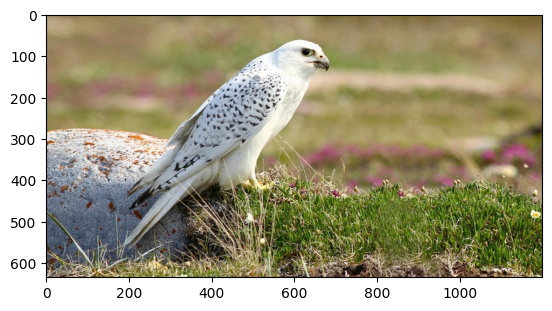

Predicted: ROADRUNNER  with a probability of 100.0%


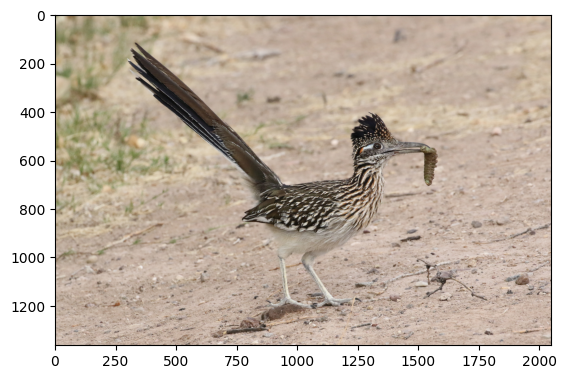

In [16]:
predict_image('./test-data/75374781-1200px.jpg', model)
predict_image('./test-data/original.jpg', model)